In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits
import sys
import copy
%matplotlib inline

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "64" 

In [3]:
import pysm3 as pysm
import pysm3.units as u

from scipy.optimize import curve_fit

In [4]:
plt.style.use("seaborn-talk")
plt.rcParams['image.cmap'] = 'viridis'

In [5]:
nside = 2048; lmax = 2048

comp = "IQU"

spectra_components = ["TT", "EE", "BB"]

datadir="/global/cscratch1/sd/jianyao/Dust/"

In [54]:
from utilities import *

In [35]:
# sky = pysm.Sky(nside=512, preset_strings=["s0"])
# maps_RJ = sky.get_emission(353 * u.GHz)

# import data

In [6]:
dust_I = datadir + "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_P = datadir + "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [6]:
dust_I

'/global/cscratch1/sd/jianyao/Dust/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits'

In [7]:
I_planck_varres, h2 = hp.read_map(dust_I, dtype=np.float64, h=True) # MJy/sr
m_planck_varres, h1 = hp.read_map(dust_P, [c + "_STOKES" for c in comp], dtype=np.float64, h=True) # K_CMB

m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr

m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0] = I_planck_varres
del I_planck_varres

In [8]:
h2

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 8192),
 ('NAXIS2', 49152),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 1),
 ('TFORM1', '1024D'),
 ('TTYPE1', 'I'),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'RING'),
 ('NSIDE', 2048),
 ('NPIX', 50331648),
 ('OBJECT', 'FULLSKY'),
 ('FIRSTPIX', 0),
 ('LASTPIX', 50331647),
 ('INDXSCHM', 'IMPLICIT'),
 ('GRAIN', 0),
 ('COMMENT', '        GRAIN =1: 1 pixel index for each pixel,'),
 ('COMMENT', '        GRAIN >1: 1 pixel index for Grain consecutive pixels'),
 ('COMMENT', '------------------------------------------------------------'),
 ('COMMENT', 'GNILC Planck thermal dust map at 353 GHz'),
 ('COMMENT',
  '(CIB-removed Galactic thermal dust map produced by the GNILC method)'),
 ('COMMENT', 'Mathieu Remazeilles'),
 ('COMMENT', 'mathieu.remazeilles@manchester.ac.uk'),
 ('COMMENT', '------------------------------------------------------------'),
 ('COMMENT', 'Planck Collaboration, "Planck intermediate results. XLVIII.'),
 ('COM

In [8]:
planck_mask_filename = datadir + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size

masking 0.7912631829579672 of the sky


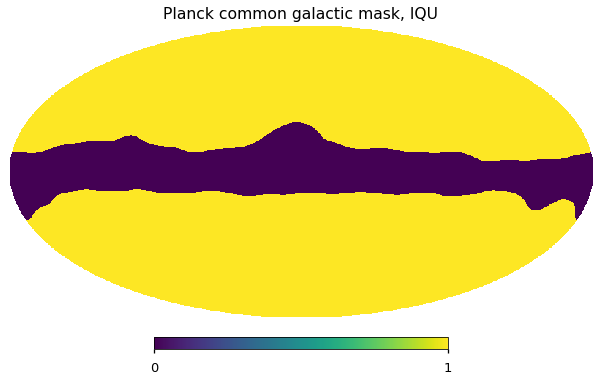

In [16]:
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}", cmap = 'viridis')

In [9]:
#monopole subtraction

planck2018_monopole = (0.13 * u.MJy / u.sr).to(u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz))

m_planck_varres[0][planck_mask] -= planck2018_monopole

In [20]:
np.save('/global/cscratch1/sd/jianyao/Dust/Dust_IQU_uK_RJ.npy', np.array((m_planck_varres)))

# fit the ps with a power law from original IQU

### ps of original IQU

In [6]:
dust_IQU = hp.read_map('/global/cscratch1/sd/jianyao/Dust/Dust_IQU_uK_RJ.fits', field = None)

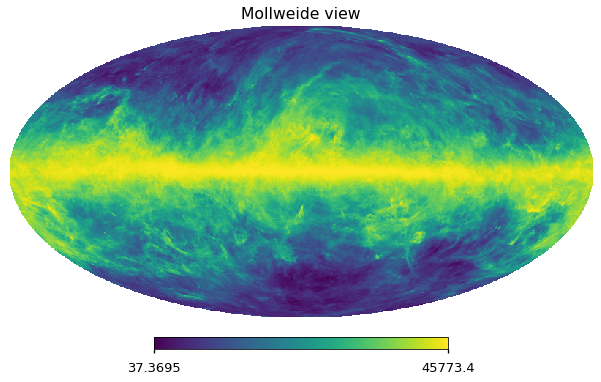

In [44]:
hp.mollview(dust_IQU[0], norm = 'hist')

In [10]:
ell, cl_norm, cl = run_anafast(dust_IQU, lmax)
np.save('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB.npy', cl)

### small iqu

In [7]:
dust_iqu = hp.read_map('/global/cscratch1/sd/jianyao/Dust/dust_gnilc_logpoltens_varres_nomono.fits', field = None)

In [42]:
dust_iqu.shape

(3, 50331648)

In [50]:
np.min(dust_iqu[0])

2.2312975

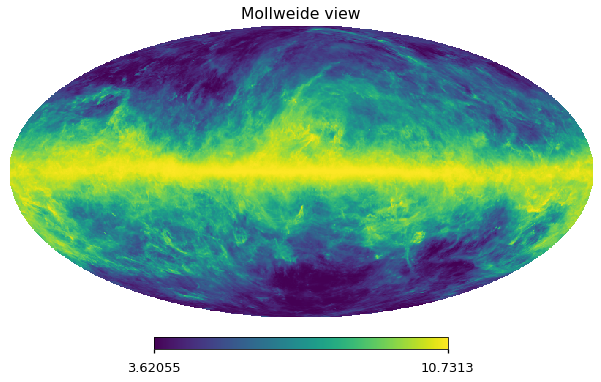

In [49]:
hp.mollview(dust_iqu[0], norm = 'hist')

### ps of IQU from iqu

In [19]:
IQU_ws = hp.read_map('/global/cscratch1/sd/jianyao/Dust/dust_gnilc_hybrid_out_nside2048_float32.fits', field = None)

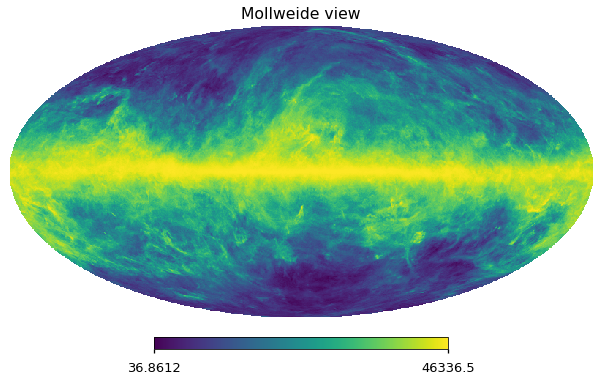

In [14]:
hp.mollview(IQU_ws[0], norm = 'hist')

In [22]:
output_nside = 2048 
output_lmax = 2 * output_nside

planck_mask_filename = datadir + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask_80 = hp.read_map(planck_mask_filename, ["GAL080"])

output_ell, output_cl_norm, cl_out_i = run_namaster(IQU_ws, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

In [23]:
np.save('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB_IQU_ws_80_sky.npy', cl_out_i)

In [92]:
ell, cl_norm, cl_dust_IQU_ws  = run_anafast(IQU_ws, lmax)

In [18]:
np.save('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB_IQU_ws.npy', cl_dust_IQU_ws)

## load cl

In [29]:
cl_dust = np.load('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB.npy', allow_pickle = True) # original IQU

B-to-E ratio w/ fitted power law at l= 110 , 0.10200653359995546
A_fit {'TT': 260728017.43497574, 'EE': 124.29944228289123, 'BB': 12.679355235685469}
gamma_fit {'TT': -1.6434288059327475, 'EE': -0.1706715869843781, 'BB': 0.1340552222885374}
A_fit {'TT': 260728017.43497574, 'EE': 126166.77260856057, 'BB': 53906.36688566407}
gamma_fit {'TT': -1.6434288059327475, 'EE': -1.6434288059327475, 'BB': -1.6434288059327475}
B-to-E ratio w/ TT power law at l= 110 , 0.42726278695351566


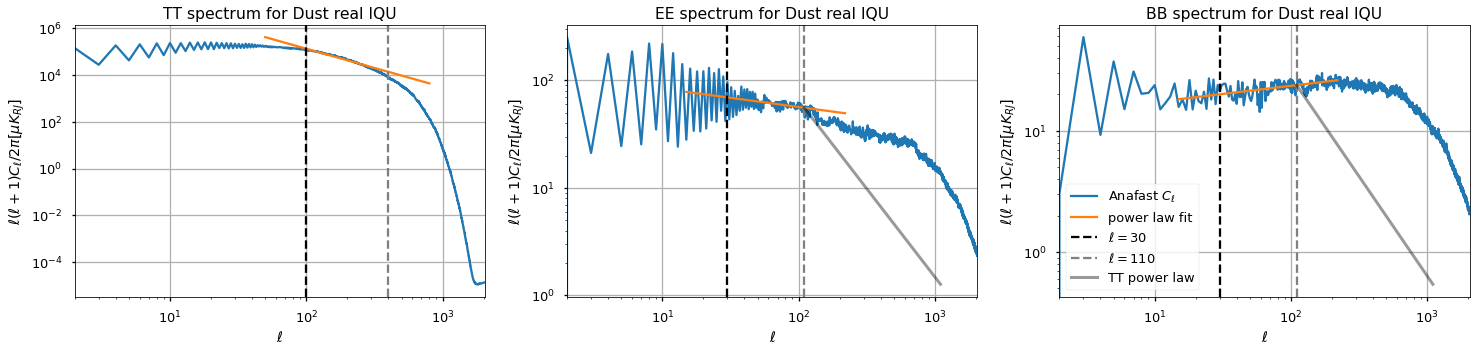

In [35]:
fit_ps(cl_dust.item(), lmax)

## correct for the beam for TT power spectra

QU maps have different resolution

In [36]:
cl_dust_de = copy.deepcopy(cl_dust.item())
bl = hp.gauss_beam(21.8/60/180*np.pi, lmax = lmax)
cl_dust_de['TT'] /= bl**2

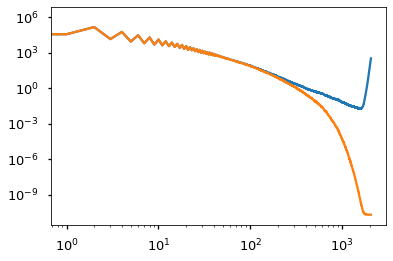

In [80]:
plt.loglog(cl_de['TT'])
plt.loglog(cl['TT'])

B-to-E ratio w/ fitted power law at l= 110 , 0.10200653359995546
A_fit {'TT': 29342099.354044024, 'EE': 124.29944228289123, 'BB': 12.679355235685469}
gamma_fit {'TT': -1.1652637037261404, 'EE': -0.1706715869843781, 'BB': 0.1340552222885374}
A_fit {'TT': 29342099.354044024, 'EE': 13329.757598648232, 'BB': 5695.30938101325}
gamma_fit {'TT': -1.1652637037261404, 'EE': -1.1652637037261404, 'BB': -1.1652637037261404}
B-to-E ratio w/ TT power law at l= 110 , 0.42726278695351594


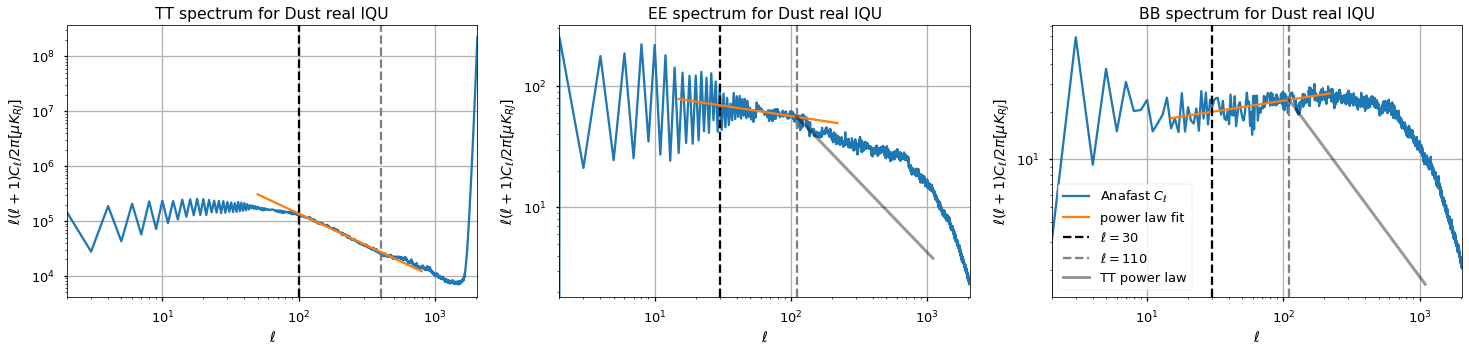

In [37]:
fit_ps(cl_dust_de, lmax)

# fit the power law for the cl from IQU_with_small_scales(big IQU transformed from small iqu)

In [29]:
cl_dust_IQU_ws = np.load('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB_IQU_ws.npy', allow_pickle = True) # transformed IQU

B-to-E ratio w/ fitted power law at l= 190 , 0.1066727877826874
A_fit {'TT': 274456739.0475475, 'EE': 1262.856681540281, 'BB': 134.71244278989525}
gamma_fit {'TT': -1.6536686186112735, 'EE': -0.5655586832753956, 'BB': -0.20250978724905777}
A_fit {'TT': 274456739.0475475, 'EE': 380968.0015483616, 'BB': 273049.33549142396}
gamma_fit {'TT': -1.6536686186112735, 'EE': -1.6536686186112735, 'BB': -1.6536686186112735}
B-to-E ratio w/ TT power law at l= 190 , 0.7167251170220972


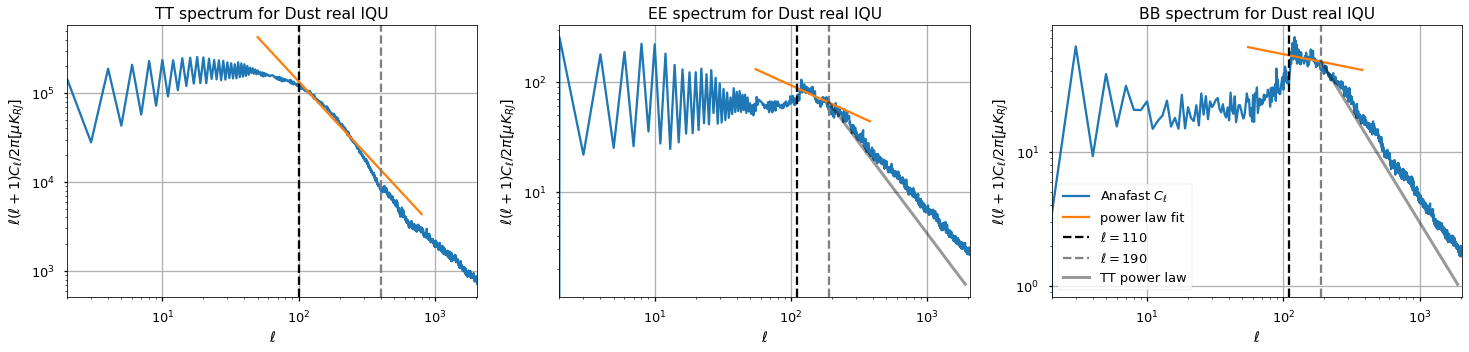

In [108]:
# ell_fit_low = {"TT":100, "EE":30, "BB":30}
# ell_fit_high = {"TT":400, "EE":110, "BB":110}

ell_fit_low = {"TT":100, "EE":110, "BB":110}
ell_fit_high = {"TT":400, "EE":190, "BB":190}
  
A_fit, gamma_fit = fit_ps(cl_dust_IQU_ws.item(), lmax)

In [11]:
A_fit

{'TT': 274456739.0475475, 'EE': 380968.0015483616, 'BB': 273049.33549142396}

In [12]:
gamma_fit

{'TT': -1.6536686186112735,
 'EE': -1.6536686186112735,
 'BB': -1.6536686186112735}

# Fit higher range of multipoles

B-to-E ratio w/ fitted power law at l= 700 , 12.772853758341556
A_fit {'TT': 18894961.66600253, 'EE': 21336.97322047721, 'BB': 272534.0385908055}
gamma_fit {'TT': -1.3235658240112926, 'EE': -1.1462077070614032, 'BB': -1.6109290085038728}
A_fit {'TT': 18894961.66600253, 'EE': 68192.09656962956, 'BB': 41480.53211947737}
gamma_fit {'TT': -1.3235658240112926, 'EE': -1.3235658240112926, 'BB': -1.3235658240112926}
B-to-E ratio w/ TT power law at l= 700 , 0.6082894383093567


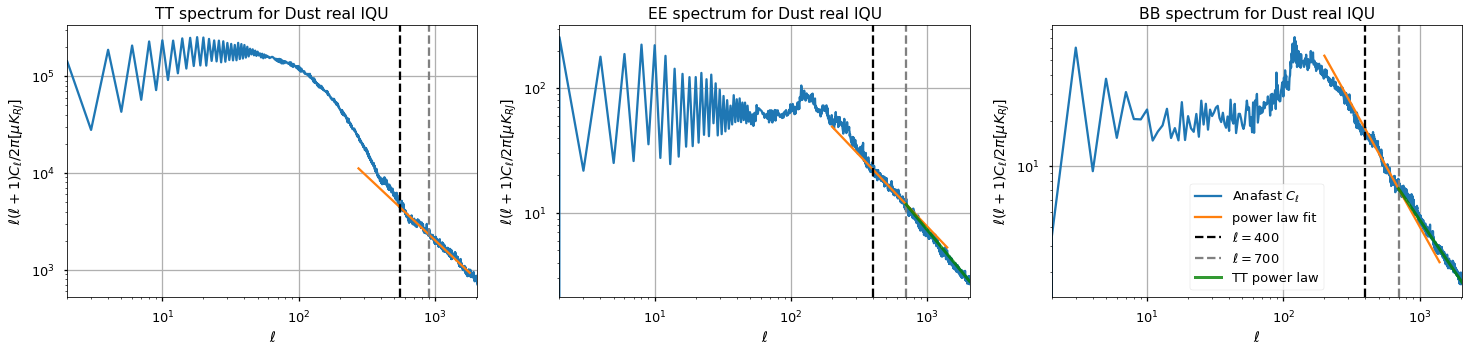

In [81]:
ell_fit_low = {"TT":550, "EE":400, "BB":400}
ell_fit_high = {"TT":900, "EE":700, "BB":700}
  
A_fit, gamma_fit = fit_ps(cl_dust_IQU_ws.item(), lmax)

In [44]:
A_fit

{'TT': 18894961.66600253, 'EE': 68192.09656962956, 'BB': 41480.53211947737}

In [45]:
gamma_fit

{'TT': -1.3235658240112926,
 'EE': -1.3235658240112926,
 'BB': -1.3235658240112926}

fit the power-law at small scales, but apply it to a larger scale!!!

In [83]:
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}

# Modulation

## rescale the original IQU to the same range of small iqu

In [8]:
print(dust_iqu[0].min())
print(dust_iqu[0].max())

2.2312975
10.867445


In [10]:
big_I = minmax(dust_IQU[0], a = dust_iqu[0].min(), b = dust_iqu[0].max())

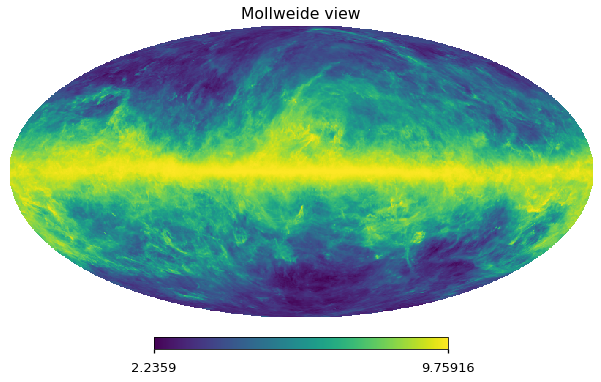

In [54]:
hp.mollview(big_I, norm = 'hist')

In [56]:
print(big_I.min())
print(big_I.max())

2.231297492980957
10.86744499206543


## modulation map for rescaled I

In [11]:
ismooth = hp.smoothing(big_I, fwhm=np.radians(5), lmax=lmax)
small_ismooth = hp.smoothing(dust_iqu[0], fwhm=np.radians(5), lmax=lmax)

In [54]:
b1 = 1.1
b2 = 2
a = 0.1

In [26]:
len(np.where(small_ismooth>4.5)[0])/(12*2048*2048)

0.5307733217875162

In [52]:
len(np.where(ismooth>2.245)[0])/(12*2048*2048)

0.5262509981791178

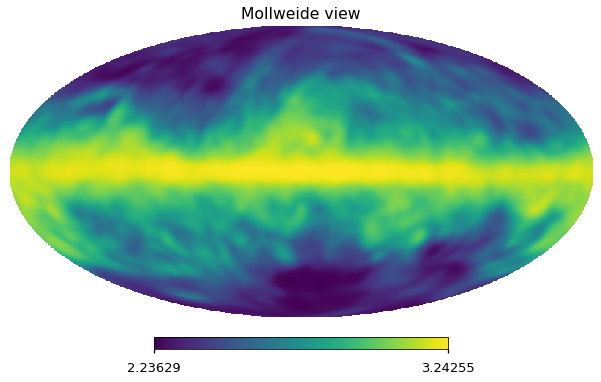

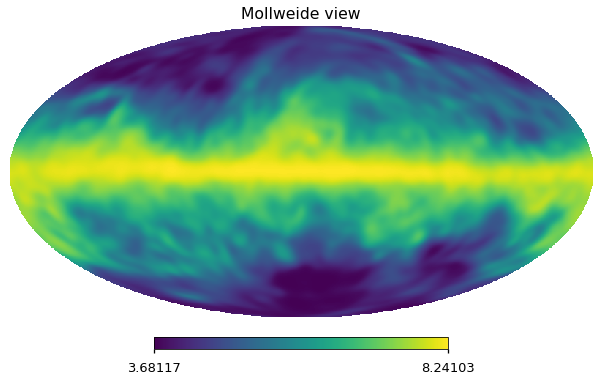

In [12]:
hp.mollview(ismooth, norm = 'hist')
hp.mollview(small_ismooth, norm = 'hist')

In [58]:
modulate_amp_pol = (ismooth) * 1.0
modulate_amp = (ismooth) * 1.0
val = 2.245
mskmd = ismooth > val
modulate_amp_pol[mskmd] = b1

modulate_amp_pol[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

modulate_amp[mskmd] = minmax(ismooth[mskmd], a=b1, b=b2) # no pixles has value larger than 4.5

modulate_amp[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

In [59]:
mskmd.sum()

26487080

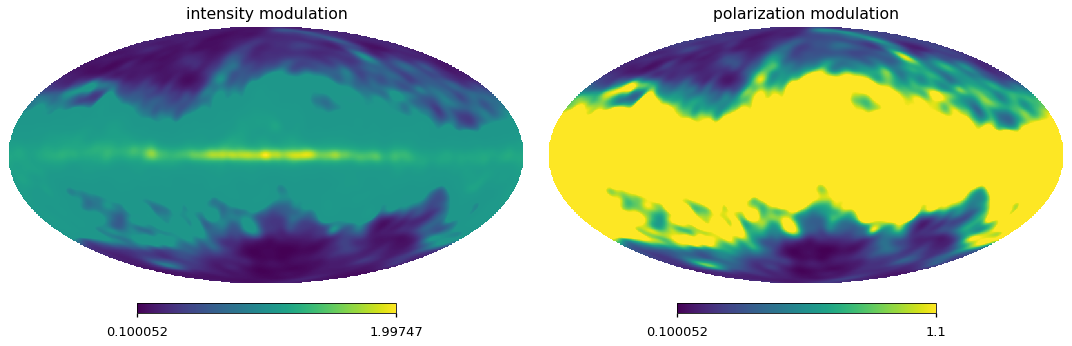

In [60]:
plt.figure(figsize=(15, 5))
hp.mollview(modulate_amp, title="intensity modulation", sub=121)
hp.mollview(modulate_amp_pol, title="polarization modulation", sub=122)

In [62]:
hp.write_map(datadir + f"My_modulate_amp_nside{nside}.fits", modulate_amp, dtype=np.float32, overwrite=True)
hp.write_map(datadir + f"My_modulate_amp_pol_nside{nside}.fits", modulate_amp_pol, dtype=np.float32, overwrite=True)

In [24]:
modulate_amp = hp.read_map(datadir + f"My_modulate_amp_nside{nside}.fits")
modulate_amp_pol = hp.read_map(datadir + f"My_modulate_amp_pol_nside{nside}.fits")

# small scales

In [50]:
output_nside = 2048 
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [92]:
hp.get_nside(modulate_amp)

2048

## original cls

In [88]:
ell

array([   0,    1,    2, ..., 2046, 2047, 2048])

In [84]:
np.random.seed(8192)
# filter small scales
small_scales_input_cl = [
    1
    * model(output_ell, A_fit[pol], gamma_fit[pol])
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for pol in spectra_components
]

<ipython-input-80-2cd6c68cb384>:55: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [85]:
alm_IQU_fullsky = hp.map2alm(dust_IQU, lmax=lmax, use_pixel_weights=True)
ii_LS_alm = np.empty_like(alm_IQU_fullsky)
ell = np.arange(lmax + 1)

for ii, pol in enumerate(spectra_components):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_IQU_fullsky[ii], (1.0 - sig_func) ** 0.2) 

log_ss = hp.synfast(
    small_scales_input_cl + [np.zeros_like(small_scales_input_cl[0])] * 3,
    lmax=output_lmax,
    new=True,
    nside=output_nside,
)

assert np.isnan(log_ss).sum() == 0
log_ss[0] *= hp.ud_grade(modulate_amp, output_nside)
log_ss[1:] *= hp.ud_grade(modulate_amp_pol, output_nside)
assert np.isnan(log_ss).sum() == 0

log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)
ii_map_out = log_ss + log_ls

In [66]:
np.save(datadir+'small_scales_cl.npy', small_scales_input_cl)

In [122]:
hp.write_map(datadir + f"ydust_gnilc_hybrid_out_nside{output_nside}_float32_on_IQU.fits",
    ii_map_out,
    dtype=np.float32,
    overwrite=True,)

## test the modulation map

In [15]:
lmax = 2048;nside = 2048;
comp = "IQU"
spectra_components = ["TT", "EE", "BB"]
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}

output_nside = 2048 
output_lmax = 2 * output_nside

In [37]:
ss_cl = np.load('/global/cscratch1/sd/jianyao/Dust/small_scales_cl.npy')
ss_cl = np.row_stack((ss_cl, np.zeros(output_lmax + 1)))

ss_ori = hp.synfast(ss_cl, lmax=output_lmax, new=True,nside=output_nside) #maps generated from IQU cls

In [39]:
ppe_modulate_amp = hp.read_map(datadir + f"modulate_amp_nside{nside}.fits")
ppe_modulate_amp_pol = hp.read_map(datadir + f"modulate_amp_pol_nside{nside}.fits")

ppe_modulate_amp_IQU = log_pol_tens_to_map(ppe_modulate_amp)
ppe_modulate_amp_pol_IQU = log_pol_tens_to_map(ppe_modulate_amp_pol)

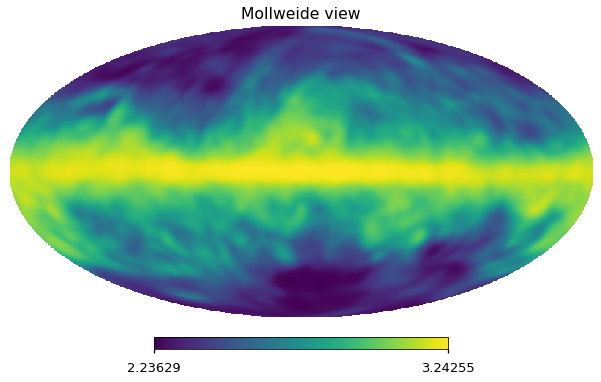

In [52]:
hp.mollview(ismooth, norm = 'hist')

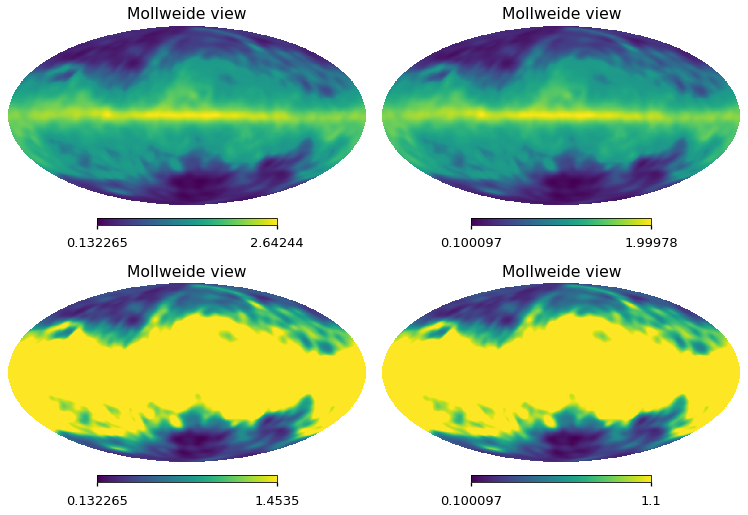

In [48]:
hp.mollview(ppe_modulate_amp_IQU, sub = 221)
hp.mollview(ppe_modulate_amp, sub = 222)
hp.mollview(ppe_modulate_amp_pol_IQU, sub = 223)
hp.mollview(ppe_modulate_amp_pol, sub = 224)

In [61]:
IQU_ss_MF = hp.read_map("/global/cscratch1/sd/jianyao/Dust/MFs/dust_IQU_only_small_scales_000.fits", field = None)

In [62]:
ell_hp, cl_norm_hp, cl_IQU_ss_only_MF = run_anafast(IQU_ss_MF, lmax=output_lmax) 

In [66]:
cl_IQU_ss_only_MF['TT'].shape

(4097,)

Text(0.5, 0.98, "ss with peppe's modulation")

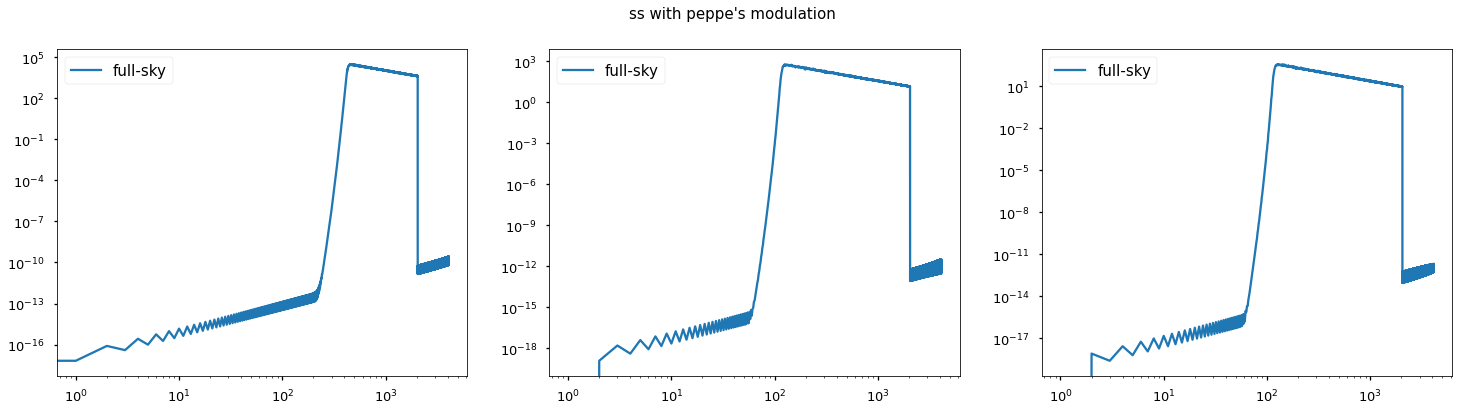

In [63]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_only[modes[i]], label = 'full-sky')
    ax.legend(fontsize = 15)
fig.suptitle("ss with peppe's modulation", fontsize = 15)

In [41]:
ss_modI = np.zeros_like(ss_ori)
ss_modI[0] = ss_ori[0]*(ismooth)
ss_modI[1:] = ss_ori[1:]*(ismooth)  

ss_mod_my = np.zeros_like(ss_ori)
ss_mod_my[0] = ss_ori[0]*(modulate_amp)
ss_mod_my[1:] = ss_ori[1:]*(modulate_amp_pol)  

ss_mod_ppe = np.zeros_like(ss_ori)
ss_mod_ppe[0] = ss_ori[0]*(ppe_modulate_amp_IQU)
ss_mod_ppe[1:] = ss_ori[1:]*(ppe_modulate_amp_pol_IQU)  

In [55]:
ls = get_large_scales(dust_IQU, lmax, spectra_components, ell_fit_high, output_nside)

IQU_ss_modI = get_small_scales(ss_modI + ls, lmax, spectra_components, ell_fit_high, output_nside)
IQU_ss_modmy = get_small_scales(ss_mod_my + ls, lmax, spectra_components, ell_fit_high, output_nside)
IQU_ss_modppe = get_small_scales(ss_mod_ppe + ls, lmax, spectra_components, ell_fit_high, output_nside)

In [56]:
ell_hp, cl_norm_hp, cl_IQU_ss_only = run_anafast(IQU_ss_modI, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_only_na = run_namaster(IQU_ss_modI, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

ell_hp, cl_norm_hp, cl_IQU_ss_modmy_only = run_anafast(IQU_ss_modmy, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_modmy_only_na = run_namaster(IQU_ss_modmy, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

ell_hp, cl_norm_hp, cl_IQU_ss_modppe_only = run_anafast(IQU_ss_modppe, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_modppe_only_na = run_namaster(IQU_ss_modppe, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

Text(0.5, 0.98, "ss with peppe's modulation")

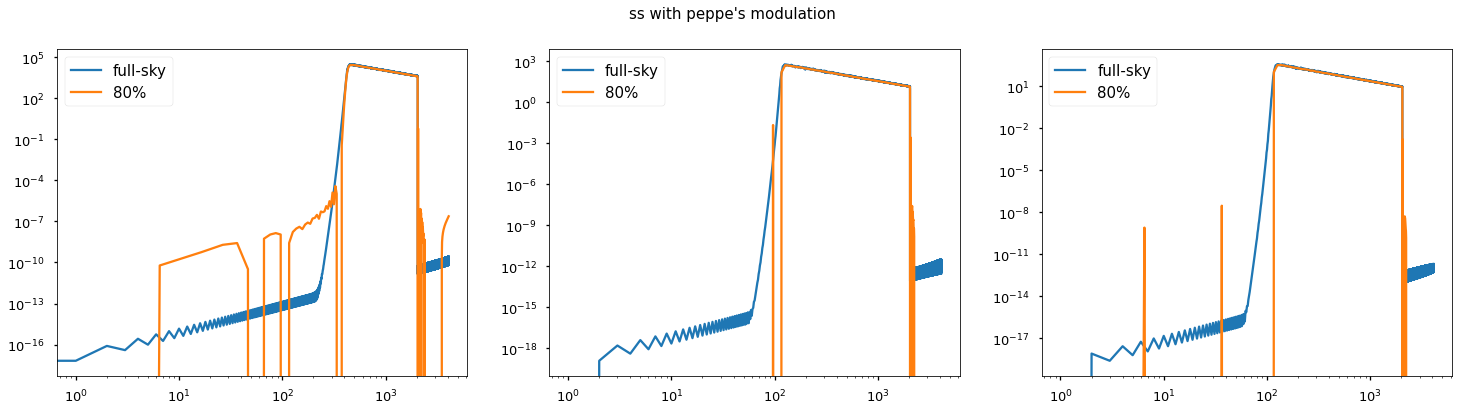

In [57]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_only[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_only_na[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss with peppe's modulation", fontsize = 15)

Text(0.5, 0.98, "ss with peppe's modulation")

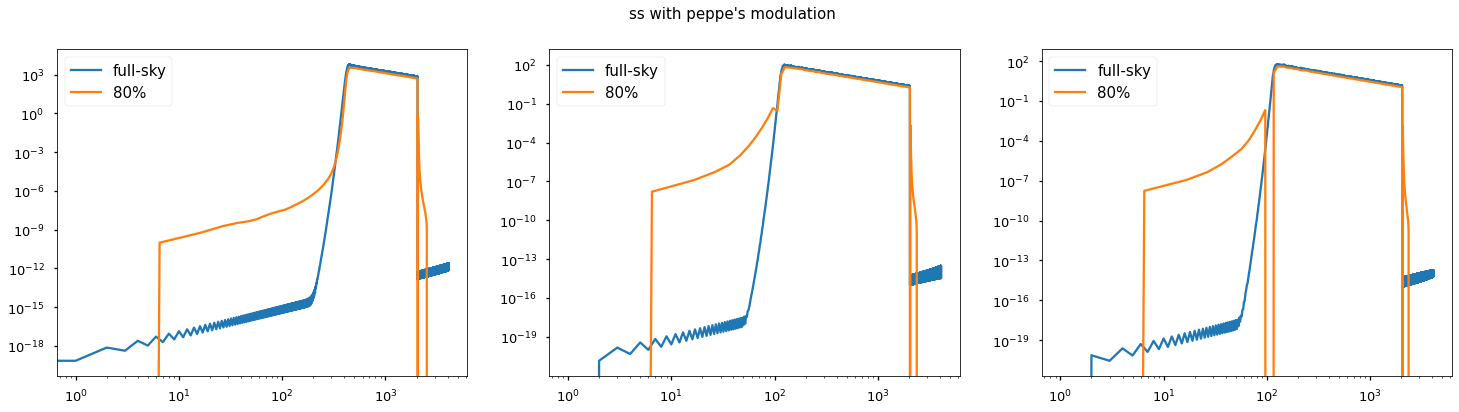

In [58]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_modmy_only[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_modmy_only_na[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss with peppe's modulation", fontsize = 15)

Text(0.5, 0.98, "ss with peppe's modulation")

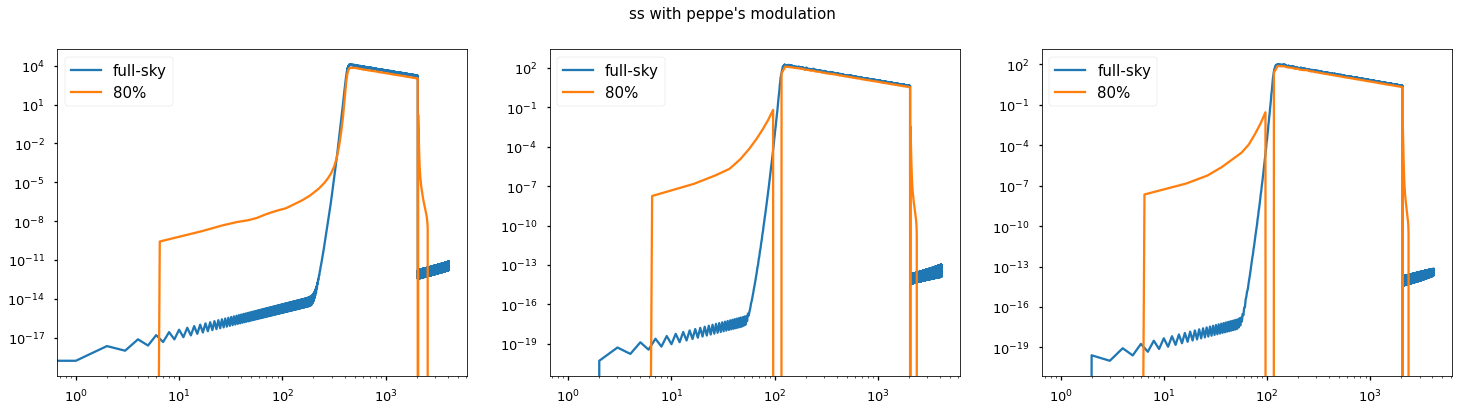

In [59]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_modppe_only[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_modppe_only_na[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss with peppe's modulation", fontsize = 15)

In [17]:
planck_mask_filename = "/global/cscratch1/sd/jianyao/Dust/" + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask_80 = hp.read_map(planck_mask_filename, ["GAL080"])

In [18]:
ell_hp, cl_norm_hp, cl_IQU_ss = run_anafast(ss_modI, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_na = run_namaster(ss_modI, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

In [26]:
ell_hp, cl_norm_hp, cl_IQU_ss_no_mod = run_anafast(ss_ori, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_na_no_mod = run_namaster(ss_ori, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

In [45]:
ell_hp, cl_norm_hp, cl_IQU_ss_modmy = run_anafast(ss_mod_my, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_na_modmy = run_namaster(ss_mod_my, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

In [46]:
ell_hp, cl_norm_hp, cl_IQU_ss_modppe = run_anafast(ss_mod_ppe, lmax=output_lmax) 
ell, cl_norm, cl_IQU_ss_na_modppe = run_namaster(ss_mod_ppe, mask=planck_mask_80, lmax=output_lmax, nlbins = 10)

Text(0.5, 0.98, "ss with peppe's modulation")

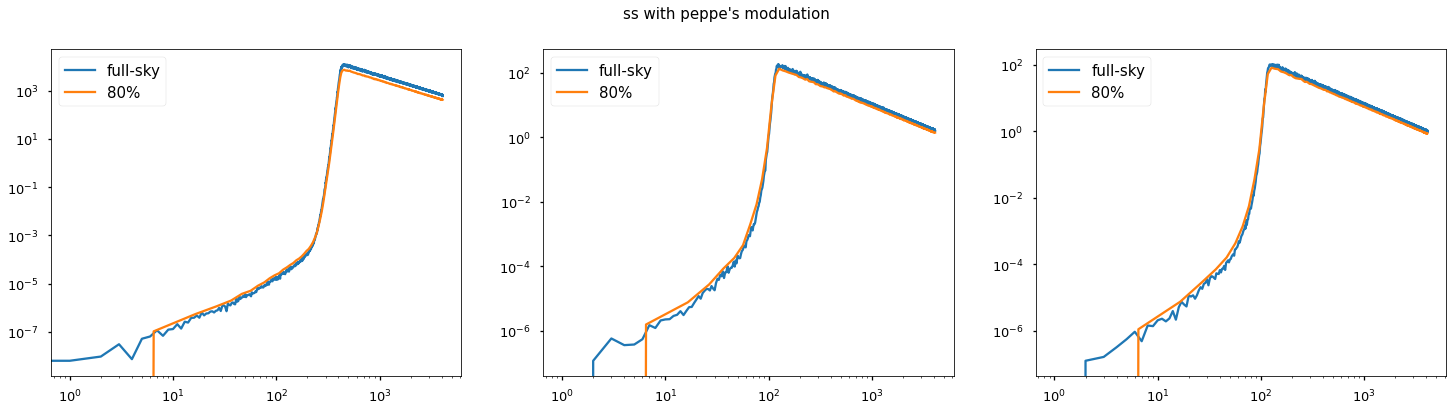

In [50]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_modppe[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_na_modppe[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss with peppe's modulation", fontsize = 15)

Text(0.5, 0.98, 'ss with my modulation')

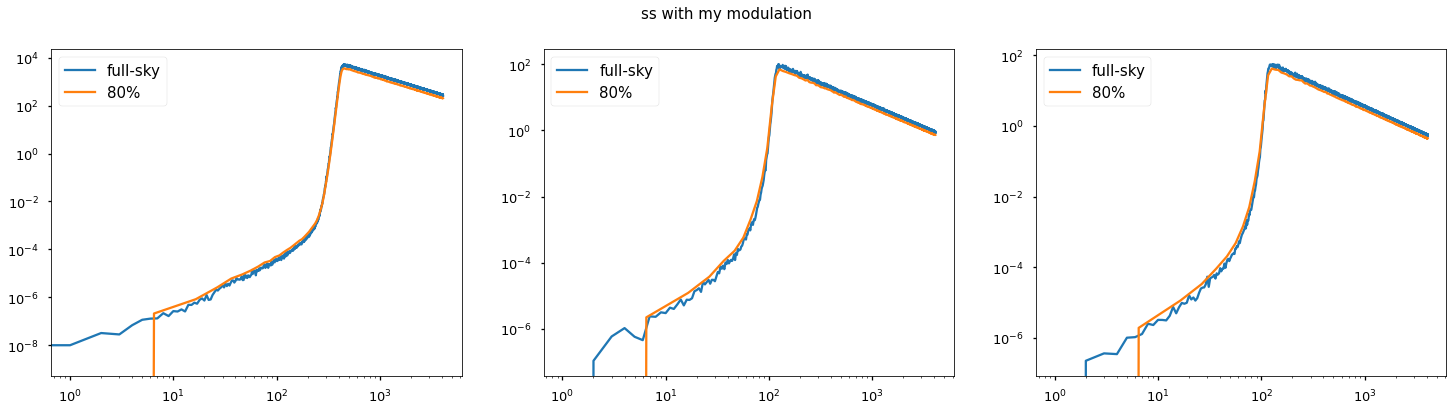

In [49]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_modmy[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_na_modmy[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss with my modulation", fontsize = 15)

Text(0.5, 0.98, 'ss no modulation')

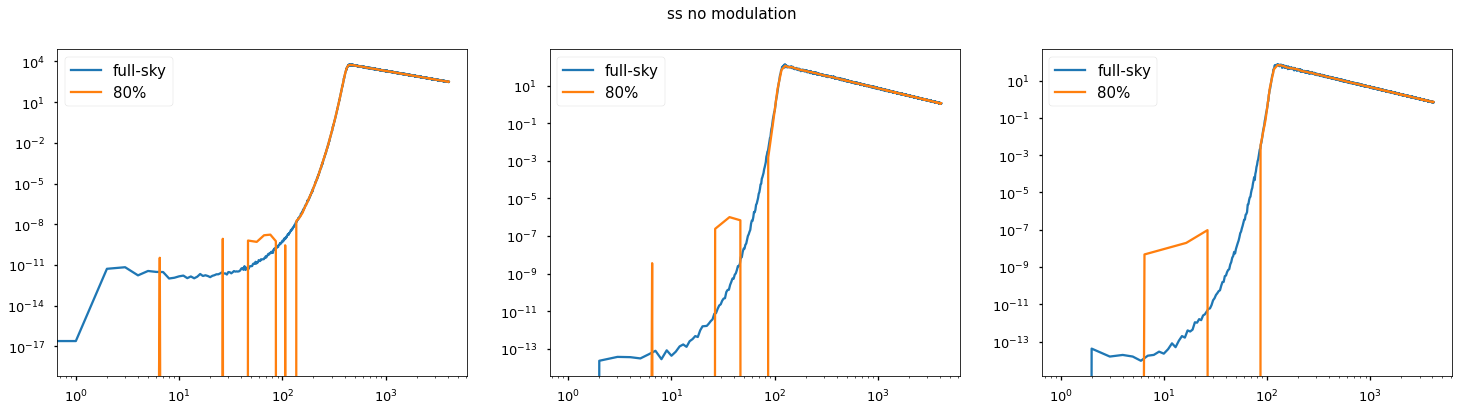

In [33]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss_no_mod[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_na_no_mod[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss no modulation", fontsize = 15)

Text(0.5, 0.98, 'ss modulated with smoothed I')

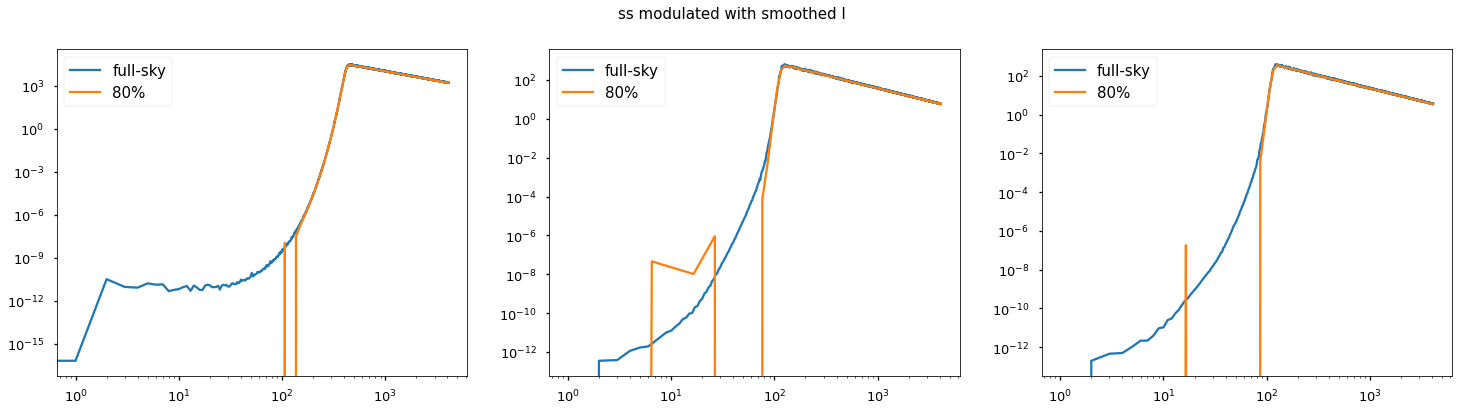

In [22]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_ss[modes[i]], label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_ss_na[modes[i]], label = '80%')
    ax.legend(fontsize = 15)
fig.suptitle("ss modulated with smoothed I", fontsize = 15)

## Maps

In [17]:
lat = 15

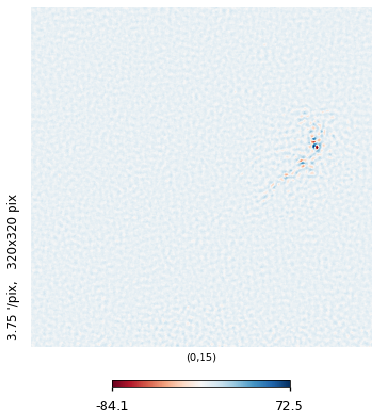

In [18]:
hp.gnomview(ii_map_out[1] - dust_IQU[1] ,cmap='RdBu',   title='', rot=[0,lat],reso=3.75,xsize=320,)

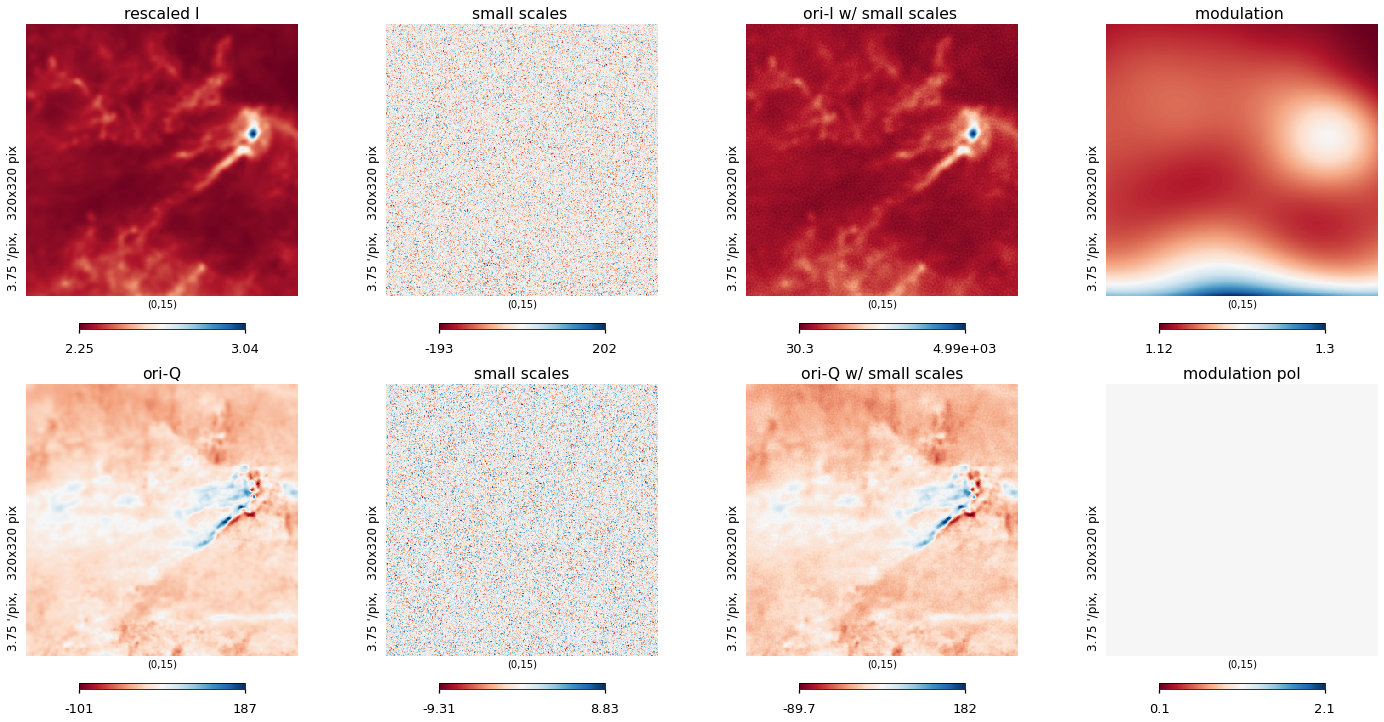

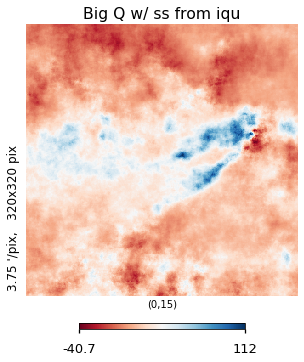

In [126]:

plt.figure(figsize=(20,10))
hp.gnomview(big_I ,cmap='RdBu',   title='rescaled I', rot=[0,lat],reso=3.75,xsize=320,  sub=241)
hp.gnomview(log_ss[0] ,cmap='RdBu',   title='small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=242)
hp.gnomview(ii_map_out[0] ,cmap='RdBu',   title='ori-I w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=243)

hp.gnomview(dust_IQU[1] ,cmap='RdBu',   title='ori-Q', rot=[0,lat],reso=3.75,xsize=320,  sub=245)
hp.gnomview(log_ss[1] ,cmap='RdBu',   title='small scales', rot=[0,lat],reso=3.75,xsize=320,  sub=246)
hp.gnomview(ii_map_out[1] ,cmap='RdBu',   title='ori-Q w/ small scales', rot=[0,lat],reso=3.75,xsize=320,  sub=247)


hp.gnomview((modulate_amp),cmap='RdBu',  title=' modulation  ', rot=[0,lat],reso=3.75,xsize=320,  sub=244, )
hp.gnomview((modulate_amp_pol),cmap='RdBu',  title=' modulation pol ', rot=[0,lat],reso=3.75,xsize=320,  sub=248)

plt.figure(figsize=(20,10))
hp.gnomview(IQU_ws[1] ,cmap='RdBu',   title='Big Q w/ ss from iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=241)
# hp.gnomview(log_ss_de[1] ,cmap='RdBu',   title='small scales from de_cl', rot=[0,lat],reso=3.75,xsize=320,  sub=242)

## power spectra of the generated maps

In [39]:
cl_dust_IQU = np.load('/global/cscratch1/sd/jianyao/Dust/cl_dust_TEB.npy', allow_pickle = True) # original IQU

In [86]:
ell, cl_norm, cl_dust_ori_IQU_ws = run_anafast(ii_map_out, lmax)

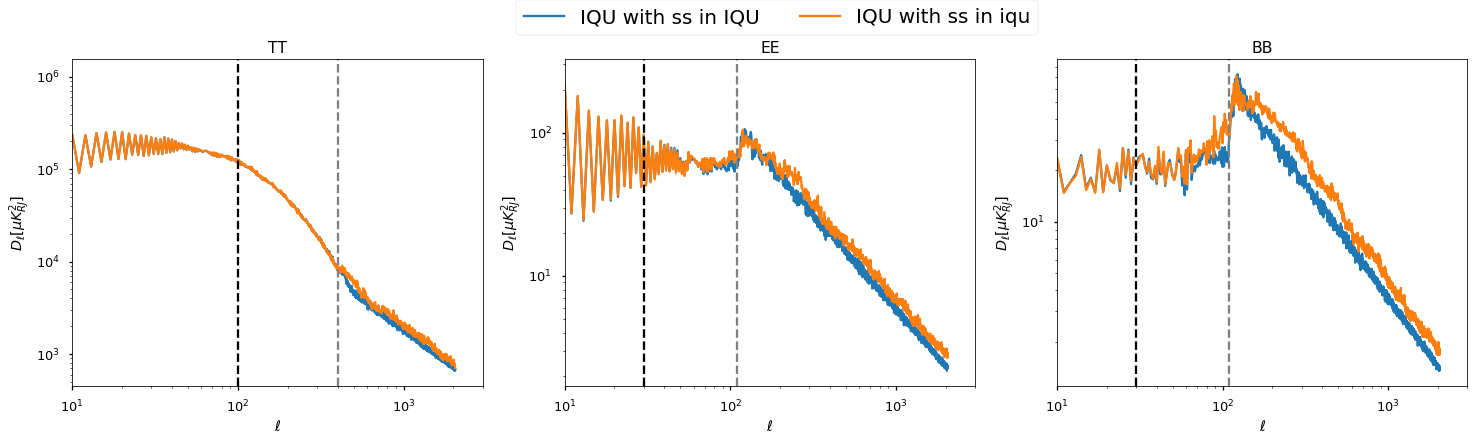

In [87]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    # ax.loglog(ell,  cl_norm*(cl_dust_IQU.item()[modes[i]]), label = 'ori');
    
    if i == 0:
        ax.loglog(ell,  cl_norm*(cl_dust_ori_IQU_ws[modes[i]]), label = 'IQU with ss in IQU'); 
        ax.loglog(ell,  cl_norm*(cl_dust_IQU_ws.item()[modes[i]]), label = 'IQU with ss in iqu'); 
    else:
        ax.loglog(ell,  cl_norm*(cl_dust_ori_IQU_ws[modes[i]])); 
        ax.loglog(ell,  cl_norm*(cl_dust_IQU_ws.item()[modes[i]])); 
    
    ax.set_title(modes[i])
    ax.set_ylabel("$ D_\ell  [\mu K_{RJ}^2]$")
    ax.set_xlabel(("$\ell$"))
    ax.set_xlim(10,3e3) 
    
    ax.axvline(ell_fit_low[modes[i]], linestyle="--", color="black")
    ax.axvline(ell_fit_high[modes[i]], linestyle="--", color="gray")

fig.legend(loc = (0.35, 0.92), ncol = 2, fontsize = 20)

# ps from Namaster

In [8]:
import pymaster as nmt

In [9]:
planck_mask_filename = datadir + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask_80 = hp.read_map(planck_mask_filename, ["GAL080"])
planck_mask_90 = hp.read_map(planck_mask_filename, ["GAL090"])
planck_mask_97 = hp.read_map(planck_mask_filename, ["GAL097"])
planck_mask_99 = hp.read_map(planck_mask_filename, ["GAL099"])
planck_mask_100 = np.ones_like(planck_mask_99)
planck_mask = [planck_mask_80, planck_mask_90, planck_mask_97, planck_mask_99, planck_mask_100]
# planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
# fsky = planck_mask.sum() / planck_mask.size

In [14]:
planck_mask_100[planck_mask_100!=1]

array([], dtype=float32)

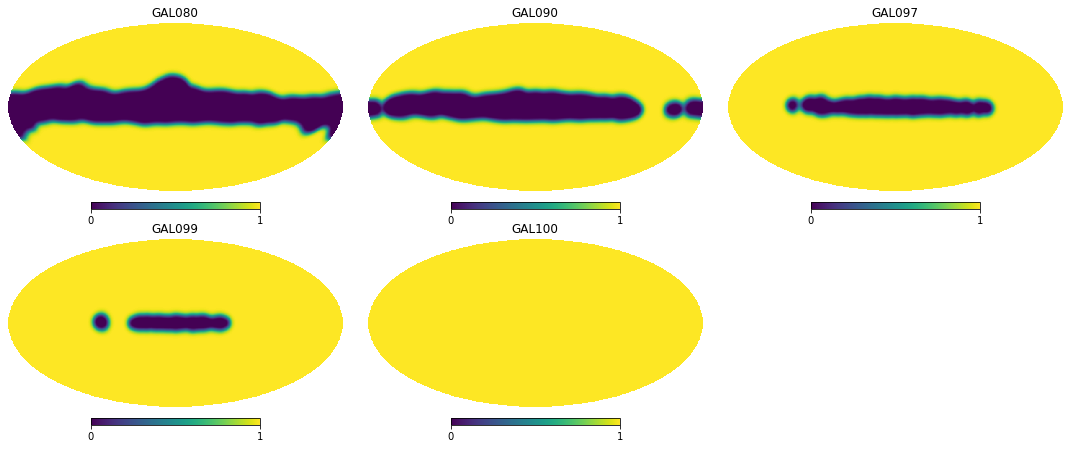

In [28]:
mask_name = ["GAL080", "GAL090", "GAL097", "GAL099", "GAL100"]
plt.figure(figsize = (15, 6))
for i in range(5):
    j = int(231+i)
    hp.mollview(planck_mask[i], min = 0, max = 1, title = mask_name[i], sub = j)

In [124]:
cl_all = []; 
# power spectrum of IQU transformed from iqu with small scales
for i in range(5):
    output_ell, output_cl_norm, cl_out_i = run_namaster(IQU_ws, mask=planck_mask[i], lmax=output_lmax, nlbins = 10)
    cl_all.append(cl_out_i);

In [12]:
cl_all_ori = []; 
# power spectrum of original IQU
for i in range(5):
    output_ell, output_cl_norm, cl_out_i = run_namaster(dust_IQU, mask=planck_mask[i], lmax=output_lmax, nlbins = 10)
    cl_all_ori.append(cl_out_i);

Text(0.5, 0.98, 'PS for m_planck_varre maps')

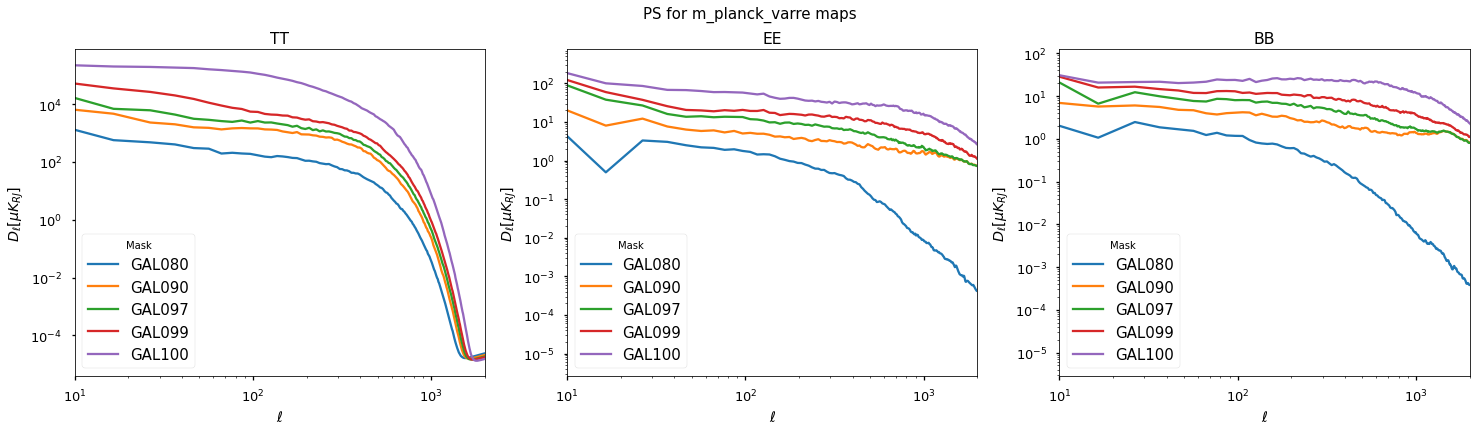

In [39]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    for j in range(5):

        ax.loglog(output_ell,  output_cl_norm*cl_all_ori[j][modes[i]],label=mask_name[j])
    ax.set_title(modes[i])
    ax.legend(title = 'Mask', fontsize=15)  
    ax.set_ylabel("$ D_\ell  [\mu K_{RJ}]$")
    ax.set_xlabel(("$\ell$"))
    ax.set_xlim(10,2e3) 
fig.suptitle('PS for m_planck_varre maps', fontsize = 15)

Text(0.5, 0.98, 'PS for large-scale only')

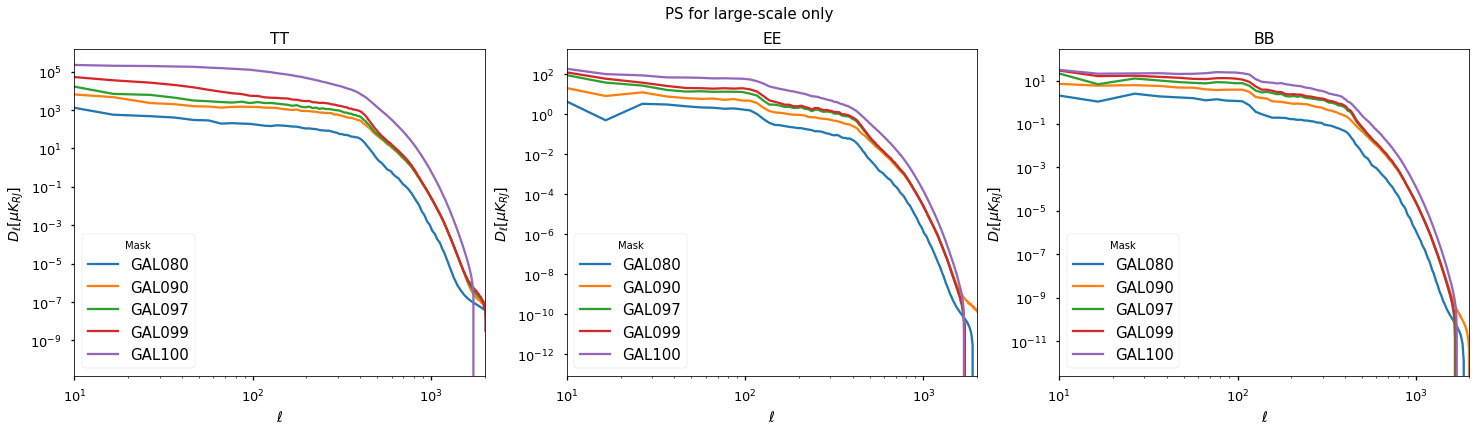

In [51]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    for j in range(5):

        ax.loglog(output_ell,  output_cl_norm*cl_all_ls_only[j][modes[i]],label=mask_name[j])
    ax.set_title(modes[i])
    ax.legend(title = 'Mask', fontsize=15)  
    ax.set_ylabel("$ D_\ell  [\mu K_{RJ}]$")
    ax.set_xlabel(("$\ell$"))
    ax.set_xlim(10,2e3) 
fig.suptitle('PS for large-scale only', fontsize = 15)

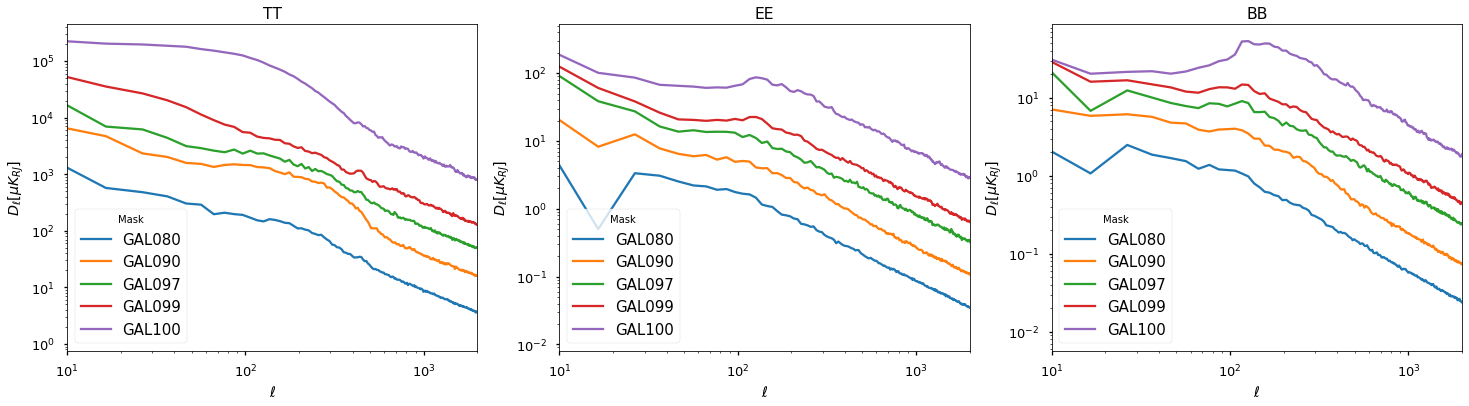

In [162]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    for j in range(5):

        ax.loglog(output_ell,  output_cl_norm*cl_all[j][modes[i]],label=mask_name[j])
    ax.set_title(modes[i])
    ax.legend(title = 'Mask', fontsize=15)  
    ax.set_ylabel("$ D_\ell  [\mu K_{RJ}]$")
    ax.set_xlabel(("$\ell$"))
    ax.set_xlim(10,2e3) 

# definition

$A_{fit} = A_{fit}*\ell^{a-b}$

In [9]:
def fit_ps(cl, lmax, EB_alone = False):

    A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
    ell = np.arange(lmax + 1)

    plt.figure(figsize=(25,5))

    for ii, pol in enumerate(spectra_components):
        plt.subplot(131+ii)
        xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
        ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
        (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
        A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

        plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Anafast $C_\ell$")
        ells = ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2]
        plt.plot(ells, model(ells, A_fit[pol], gamma_fit[pol]), label="power law fit")

        plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
        plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
        plt.grid()
        plt.title(f"{pol} spectrum for Dust real IQU" )

        plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(2, lmax)
        # print(f"Spectral index from fit for {pol}={gamma_fit[pol]}")
    print(f"B-to-E ratio w/ fitted power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 

    print('A_fit', A_fit)
    print('gamma_fit', gamma_fit)
    
    if EB_alone:
        
        return A_fit, gamma_fit
    
    else:       
        for ii, pol in enumerate(spectra_components[1:] ):
            #we change the EE and BB power laws 
            A_fit[pol] =A_fit[pol]*  ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit['TT' ] ) 
            gamma_fit[pol] = gamma_fit['TT'] 
            plt.subplot(132+ii)

            ells = ell[ell_fit_high[pol] :ell_fit_high[pol]*10]
            plt.plot(ells, model(ells, A_fit[pol], gamma_fit[pol]),linewidth=3, alpha=.8, color='g', label="TT power law")

        print('A_fit', A_fit)
        print('gamma_fit', gamma_fit)  
        print(f"B-to-E ratio w/ TT power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 
        plt.legend() 

        return A_fit, gamma_fit

def model(ell, A, gamma):
    out = A * ell ** gamma
    if ell[0] == 0:
        out[0:2] = 0
    return out

def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]; cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]; cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m

minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

def run_namaster(m, mask, lmax, nlbins=1):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0]])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl